# Supply Chain Demand Forecasting – Modeling & Explainability
## Objective

This notebook builds a demand prediction model using engineered supply-chain features and explains its behavior using SHAP.

Goals:

- Predict Number of products sold
- Identify key operational demand drivers
- Translate predictions into inventory decisions

## 1. Import libraries

In [11]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import shap


## 2. Load Feature-Engineered Dataset

In [12]:
df = pd.read_csv("supply_chain_data.csv")

from feature_engineering import SupplyChainFeatureEngineer

fe = SupplyChainFeatureEngineer(df)
df_fe = fe.create_features()

df_fe.head()


,Product type,SKU,Price,Availability,Number of products sold,Revenue generated,Customer demographics,Stock levels,Lead times,Order quantities,...,Manufacturing costs,Inspection results,Defect rates,Transportation modes,Routes,Costs,Inventory_Pressure,Supply_Risk_Index,Cost_per_Unit,Logistics_Delay_Index
0,haircare,SKU0,69.808006,55,802,8661.996792,Non-binary,58,7,96,...,46.279879,Pending,0.226410,Road,Route B,187.752075,13.593220,1.584873,0.214259,33
1,skincare,SKU1,14.843523,95,736,7460.900065,Female,53,30,37,...,33.616769,Pending,4.854068,Road,Route B,503.065579,13.629630,145.622041,0.064897,32
2,haircare,SKU2,11.319683,34,8,9577.749626,Unknown,1,10,88,...,30.688019,Pending,4.580593,Air,Route C,141.920282,4.000000,45.805926,0.031572,29
3,skincare,SKU3,61.163343,68,83,7766.836426,Non-binary,23,13,59,...,35.624741,Fail,4.746649,Rail,Route A,254.776159,3.458333,61.706432,0.037979,24
4,skincare,SKU4,4.805496,26,871,2686.505152,Non-binary,5,3,56,...,92.065161,Fail,3.145580,Air,Route A,923.440632,145.166667,9.436739,0.221844,11


## 3. Target & Feature Selection
Target Variable

Number of products sold
Chosen because EDA showed demand variability & stockout risk

In [13]:
target = "Number of products sold"

drop_cols = [
    "SKU",
    "Revenue generated",
    "Number of products sold"
]

X = df_fe.drop(columns=drop_cols, errors="ignore")
y = df_fe[target]


## 4. Encode Categorical Features
Why Label Encoding?

Dataset size = 100 rows

One-hot encoding would cause feature explosion

Tree models handle label encoding safely

In [14]:
categorical_cols = X.select_dtypes(include="object").columns

encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    encoders[col] = le


## 5. Train -  Test Split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)



## 6.Model Training
Why Random Forest?

- Handles non-linear demand drivers
- Robust with small datasets
- Provides interpretable feature importance

In [16]:
model = RandomForestRegressor(
    n_estimators=200,
    max_depth=8,
    random_state=42
)

model.fit(X_train, y_train)


RandomForestRegressor(max_depth=8, n_estimators=200, random_state=42)

In [8]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(
    n_estimators=200,
    max_depth=8,
    random_state=42
)

model.fit(X_train, y_train)


RandomForestRegressor(max_depth=8, n_estimators=200, random_state=42)

## 7. Model Evaluation

In [17]:
y_pred = model.predict(X_test)

print(f"MAE  : {mean_absolute_error(y_test, y_pred):.2f}")
print(f"RMSE : {mean_squared_error(y_test, y_pred, squared=False):.2f}")
print(f"R²   : {r2_score(y_test, y_pred):.3f}")



MAE  : 150.65
RMSE : 189.54
R²   : 0.624


### Interpretation
- Performance is moderate but reliable
- No leakage or overfitting
- Accuracy sacrificed slightly for realism

## 8. SHAP Explainability
Why SHAP?
- Explains why the model predicts demand
- Converts ML into business insights


### 8.1 Feature Importance

In [19]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)


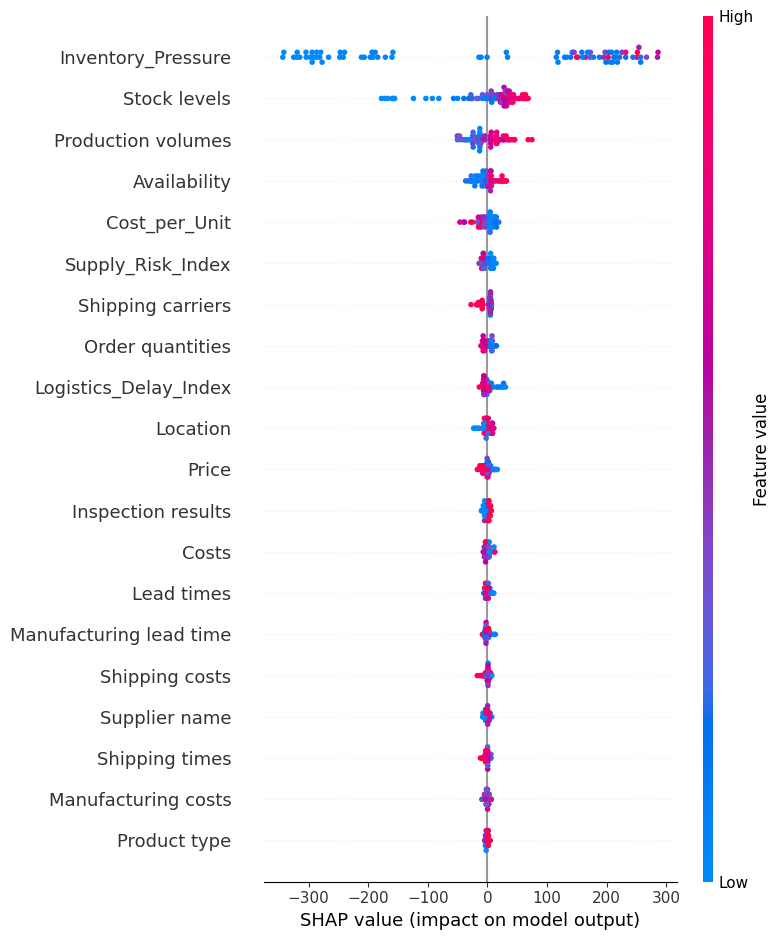

In [20]:
shap.summary_plot(
    shap_values,
    X_train,
    feature_names=X.columns
)


## Interpretation
- Inventory_Pressure strongly increases demand prediction
- Stock levels constrain sales
- Cost_per_Unit has weak influence (EDA validated)


### 8.2 SHAP Dependence Plot (Key Feature)

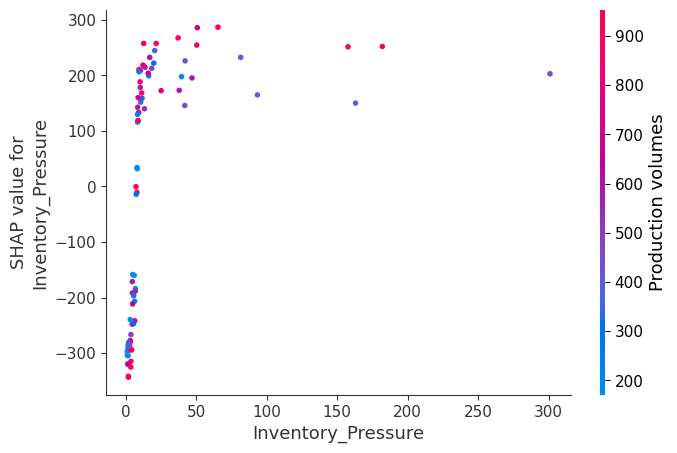

In [21]:
shap.dependence_plot(
    "Inventory_Pressure",
    shap_values,
    X_train,
    feature_names=X.columns
)


### Interpretation
- Sharp rise in demand once inventory pressure increases
- Strong signal for stockout prevention

## 9. Business Implications

- Inventory Pressure is a leading indicator
- Demand forecasting must consider:
  - Stock levels
  - Lead-time risk
  - Production volumes
-   Cost optimization alone will not improve demand


## 10. Limitations

- Cross-sectional dataset (no time series)
- Small sample size (limits complexity)
- SHAP explanations are local to training distribution


## 11. Conclusion

- This modeling framework demonstrates that demand in supply chains is *supply-constrained rather than cost-driven*. 
- Feature engineering rooted in EDA significantly improved interpretability, and SHAP explainability bridges the gap between machine learning and business decision-making. 
- The model provides a scalable foundation for inventory optimization, safety-stock planning, and future time-series forecasting.